In [31]:
import os
import sys
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import OrderedDict
import itertools as it
from functools import reduce 
import time

In [2]:
data=pd.read_json('../data/Sarcasm_Headlines_Dataset.json', lines=True)

In [3]:
data.head()
data[['headline','is_sarcastic']].head()

,headline,is_sarcastic
0,former versace store clerk sues over secret 'b...,0
1,the 'roseanne' revival catches up to our thorn...,0
2,mom starting to fear son's web series closest ...,1
3,"boehner just wants wife to listen, not come up...",1
4,j.k. rowling wishes snape happy birthday in th...,0


Well, now that we have our data, let's analyze it. I shall start with a bag of words.
I shall remove all stop words and try to remove suffixes, such as plurals and tense.
The next couple parts are borrowed from work by Tanumoy Nandy at
https://www.kaggle.com/tanumoynandy/sarcasm-detection-lstm

Text(0.5, 1.0, 'Sarcasm vs Non-sarcasm')

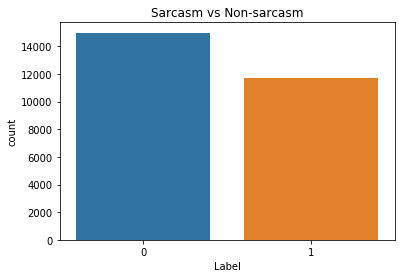

In [5]:
# Get prior proportions
sns.countplot(data.is_sarcastic)
plt.xlabel('Label')
plt.title('Sarcasm vs Non-sarcasm')

In [6]:
# Simplest method to determine sarcasm, prior rates
prior=(len(data)-sum(data['is_sarcastic']))/len(data)
prior

0.5610468381444457

In [7]:
# remove upper case, weird white space and punctuation
data['headline'] = data['headline'].apply(lambda x: x.lower())
data['headline'] = data['headline'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x)))
data[['headline','is_sarcastic']].head()

,headline,is_sarcastic
0,former versace store clerk sues over secret bl...,0
1,the roseanne revival catches up to our thorny ...,0
2,mom starting to fear sons web series closest t...,1
3,boehner just wants wife to listen not come up ...,1
4,jk rowling wishes snape happy birthday in the ...,0


In [120]:
# I'm gonna be dumb and use a good 'Ol python dictionary to hold the word counts
# word: [serious_int, sarcastic_int]
counts={}
def add_term(dicto, word, sarcasm):
    if not word in dicto:
        dicto[word] = [0,0]
        dicto[word][sarcasm] = 1  #if this is the first time we see the word, make its count the step
    else:
        dicto[word][sarcasm] += 1 #increment the count with another sighting
        
for entry, sarc in zip(data['headline'],data['is_sarcastic']):
    for word in entry.split(" "):
        add_term(counts, word, sarc)

In [121]:
# Get the ranks of each word
the_counts=OrderedDict(sorted(counts.items(), reverse=True, key=lambda x: x[1][1]))

In [122]:
for i,count in enumerate(the_counts):
    the_counts[count][1]=i

In [123]:
the_counts=OrderedDict(sorted(counts.items(), reverse=True, key=lambda x: x[1][0]))

In [124]:
for i,count in enumerate(the_counts):
    the_counts[count][0]=i

In [125]:
# At this point, counts now has a list of rankings for each word for sarcasm vs not sarcasm
# Let's see if we can use these rankings to determine the sarcasm of the headline
confusion_matrix={}
def add_term(dicto, case):
    if not case in dicto:
        dicto[case] = 1  #if this is the first time we see the word, make its count the step
    else:
        dicto[case] += 1 #increment the count with another sighting
        
for entry, sarc in zip(data['headline'],data['is_sarcastic']):
    # For every headline, add up the rankings of each word for each class
    r=list(itertools.chain(*[the_counts[word] for word in entry.split(" ")]))

    # Get the predicted and real sarcasm
    result=(sum(r[::2]) > sum(r[1::2]),bool(sarc))
    add_term(confusion_matrix, result)

In [126]:
confusion_matrix

{(False, False): 13860,
 (True, True): 11049,
 (True, False): 1125,
 (False, True): 675}

In [127]:
accuracy=(confusion_matrix[(True, True)]+confusion_matrix[(False, False)])/len(data)
accuracy

0.9326069864090756

In [66]:
# Let's do the same thing... but Naive Bayes!
counts={}
def add_term(dicto, word, sarcasm):
    if not word in dicto:
        dicto[word] = [0,0]
        dicto[word][sarcasm] = 1  #if this is the first time we see the word, make its count the step
    else:
        dicto[word][sarcasm] += 1 #increment the count with another sighting

for entry, sarc in zip(data['headline'],data['is_sarcastic']):
    for word in entry.split(" "):
        add_term(counts, word, sarc)
v=list(itertools.chain(*list(counts.values())))
num_serious_words=sum(v[0::2])
num_sarcastic_words=sum(v[1::2])


In [67]:
for i,count in enumerate(counts):
    counts[count][0]=counts[count][0]/num_serious_words
    counts[count][1]=counts[count][1]/num_sarcastic_words

In [68]:
confusion_matrix={}
def add_term(dicto, case):
    if not case in dicto:
        dicto[case] = 1  #if this is the first time we see the word, make its count the step
    else:
        dicto[case] += 1 #increment the count with another sighting
        
for entry, sarc in zip(data['headline'],data['is_sarcastic']):
    # For every headline, add up the rankings of each word for each class
    r = list(itertools.chain(*[counts[word] for word in entry.split(" ")]))
    p_serious = reduce((lambda x, y: x * y), r[0::2]) 
    p_sarcasm = reduce((lambda x, y: x * y), r[1::2]) 
    # Get the predicted and real sarcasm
    result=(p_serious < p_sarcasm, bool(sarc))
    add_term(confusion_matrix, result)

In [69]:
accuracy=(confusion_matrix[(True, True)]+confusion_matrix[(False, False)])/len(data)
accuracy

0.9630461642143098

In [73]:
accuracy(confusion_matrix)

0.9630461642143098

In [164]:
# So, now that I have shown that each of these methods 
# at least regurgitate data, let's actually test them. 
# In these scenarios I have given the algorithms the 
# ability to memorize its input. Now, I'll give them 
# a train and test set
def k_fold_cross_validation(data, k):
    """
    params:
        data: This should be a pandas data frame
        k: This is an int indicating the folds of the data to be performed
           If k is 0, perform LOO cross-validation: TODO
           If k is 1, the data is both test and train
    output:
        train: This is a pandas data frame
        test: This is a pandas data frame
        cross: This is which k we shall be working on
    """
    if k == 1:
        yield(data, data, k)
        return()
    if k == 0:
        for i, value in enumerate(data): # double check
            train = data[:i].append(data[(i+1):])
            test = data[i:(i+1)]
            yield(train, test, i)
    size = len(data)
    for cross in range(k):
        start = int(cross*size/k)
        stop = int((cross+1)*size/k)
        train = data[:start].append(data[stop:])
        test = data[start:stop]
        yield(train,test,cross)

In [21]:
small_data=data[:6]

In [22]:
for fold in k_fold_cross_validation(small_data,3):
    display(fold[1])

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret bl...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the roseanne revival catches up to our thorny ...,0


,article_link,headline,is_sarcastic
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear sons web series closest t...,1
3,https://politics.theonion.com/boehner-just-wan...,boehner just wants wife to listen not come up ...,1


,article_link,headline,is_sarcastic
4,https://www.huffingtonpost.com/entry/jk-rowlin...,jk rowling wishes snape happy birthday in the ...,0
5,https://www.huffingtonpost.com/entry/advancing...,advancing the worlds women,0


In [23]:
small_data[:0]

,article_link,headline,is_sarcastic


In [24]:
# Ok, now let's get a function that can perform these operations
# without any outside help
def run_algorithm(train, test, algorithm):
    """
    params:
        train: a pandas data frame of the data
        test: a pandas data frame of the data
        algorithm: a pointer to a function that takes in data and outputs predictions
    outputs:
        confusion_matrix: The confusion matrix of the boolean classification
        duration: The amount of time that this took to run
    """
    start = time.time()
    training_info = algorithm(train)
    confusion_matrix = algorithm(test, training_info)
    duration = time.time() - start
    return(confusion_matrix, duration)

In [82]:
def prior(data,info=None):
    values = None
    if info is None:
        prior=sum(data['is_sarcastic'])/len(data)
        values = prior
    else:
        answer = 0
        # If 1 is more common than 0, guess 1.
        if info > 0.5:
            answer = 1
        confusion_matrix = {x:0 for x in it.product([0,1],repeat=2)}
        for x in data['is_sarcastic']:
            confusion_matrix[(answer,x)] += 1
        values = confusion_matrix
    return(values)

In [130]:
def add_term(dicto, word, sarcasm):
        if not word in dicto:
            dicto[word] = [0,0]
            dicto[word][sarcasm] = 1  #if this is the first time we see the word, make its count the step
        else:
            dicto[word][sarcasm] += 1 #increment the count with another sighting

In [178]:
def NB(data,info=None):
    values = None
    counts = {}
    if info is None:
        for entry, sarc in zip(data['headline'],data['is_sarcastic']):
            for word in entry.split(" "):
                add_term(counts, word, sarc)
        v=list(it.chain(*list(counts.values())))
        num_serious_words=sum(v[0::2])
        num_sarcastic_words=sum(v[1::2])
        for word in counts:
            counts[word][0] /= num_serious_words
            counts[word][1] /= num_sarcastic_words
        values = counts
    else:
        confusion_matrix = {x:0 for x in it.product([0,1],repeat=2)}
        for entry, sarc in zip(data['headline'],data['is_sarcastic']):
            # For every headline, multiply the frequency of each word for each class
            # If a word in the test set is not found in the training set, ignore it
            r = list(it.chain(*[info.get(word, [1,1]) for word in entry.split(" ")]))
            p_serious = reduce((lambda x, y: x * y), r[0::2]) 
            p_sarcasm = reduce((lambda x, y: x * y), r[1::2]) 
            result=(p_serious < p_sarcasm, bool(sarc))
            confusion_matrix[result] += 1
        values = confusion_matrix
    return(values)

In [179]:
def NB_rank(data,info=None):
    values = None
    counts = {}
    if info is None:
        for entry, sarc in zip(data['headline'],data['is_sarcastic']):
            for word in entry.split(" "):
                add_term(counts, word, sarc)
        # Get the ranks of each word in reference to serious
        ordered_counts_ser=OrderedDict(sorted(counts.items(), reverse=True, key=lambda x: x[1][0]))
        for i,count in enumerate(ordered_counts_ser):
            ordered_counts_ser[count][0]=i
        # Get the ranks of each word in reference to sarcasm
        ordered_counts_sarc=OrderedDict(sorted(ordered_counts_ser.items(), reverse=True, key=lambda x: x[1][1]))
        for i,count in enumerate(ordered_counts_sarc):
            ordered_counts_sarc[count][1]=i
        values = ordered_counts_sarc
    else:
        confusion_matrix = {x:0 for x in it.product([0,1],repeat=2)}
        for entry, sarc in zip(data['headline'],data['is_sarcastic']):
            # If a word in the test set is not found in the training set, ignore it
            r=list(itertools.chain(*[info.get(word,[0,0]) for word in entry.split(" ")]))
            # For every headline, add up the rankings of each word for each class
            psar = sum(r[1::2])
            pser = sum(r[0::2])
            result=(pser > psar,bool(sarc))
            confusion_matrix[result] += 1
        values = confusion_matrix
    return(values)

In [139]:
def accuracy(confusion_matrix):
    correct = confusion_matrix[(True, True)]+confusion_matrix[(False, False)]
    return(correct/sum(list(confusion_matrix.values())))

In [75]:
size=1000
medium_data=data#[:size]

In [76]:
medium_data.head()

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret bl...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the roseanne revival catches up to our thorny ...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear sons web series closest t...,1
3,https://politics.theonion.com/boehner-just-wan...,boehner just wants wife to listen not come up ...,1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,jk rowling wishes snape happy birthday in the ...,0


Text(0.5, 1.0, 'Sarcasm vs Non-sarcasm')

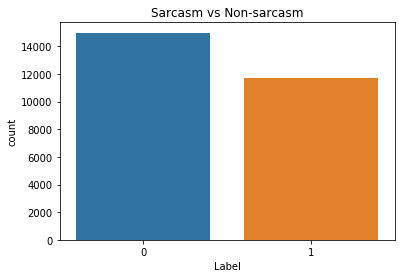

In [77]:
# Get prior proportions
sns.countplot(medium_data.is_sarcastic)
plt.xlabel('Label')
plt.title('Sarcasm vs Non-sarcasm')

In [175]:
confusion_matrix, duration = run_algorithm(medium_data, medium_data, NB)
accuracy(confusion_matrix)

0.9630461642143098

In [188]:
acc = 0
k=0
for train, test, cross in k_fold_cross_validation(medium_data, k): # never before seen words
    confusion_matrix, duration = run_algorithm(train, test, NB)
    acc += accuracy(confusion_matrix)
print(acc/len(medium_data))

0.00011232168931820734
